# Caso de Negocio -- Scholastic Travel Company

La agencia de viajes Scholastic Travel Company desea crear una estrategia de retención de clientes. Para esto, es necesario que el equipo de analítica cree un modelo de predicción para determinar qué clientes de los que viajaron el año anterior (2011) van a reservar nuevamente el año siguiente (2012). 

En este Notebook se trabajarán los siguientes temas: 

- Separación de Datos en Train/Val/Test
- Análisis de Correlaciones
- Ajuste del mejor SVM 
- Métricas de Evaluación


<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/juancop/metodos_analitica_2/blob/main/02_SVM/02_caso_de_negocio/02_caso_de_negocio.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/juancop/metodos_analitica_2/blob/dev/01_optimization/02_SVM/02_caso_de_negocio/02_caso_de_negocio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
  
</table>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

A continuación se carga la base de datos de STC, que cuenta con 2389 registros de clientes que viajaron en 2011 y tiene una variable que determina si el cliente viajó nuevamente en 2012. 

In [2]:
df = pd.read_csv('STC_datos_grupos.csv', sep = ';')

In [3]:
df.shape

(2389, 56)

In [4]:
df.head()

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,40557,40557,...,K,Elementary,K->Elementary,H,1,0.06364617,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,40557,40564,...,Middle,Middle,Middle->Middle,H,1,0.025882353,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,40558,40560,...,Middle,Middle,Middle->Middle,H,1,0.02513089,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,40558,40560,...,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,40559,40564,...,Middle,Middle,Middle->Middle,H,0,0.1125,0.910112,8,M-L,0


Se cuenta con 54 variables independientes y una variable explicativa, `Retained.in.2012.`. 

# EDA

Se realizará una exploración de los datos con la variable de respuesta.

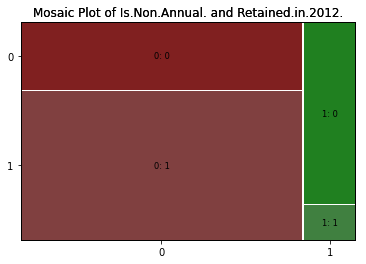

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Define a function to format the labels
def labelizer(keys):
    return f'{keys[0]}: {keys[1]}'

# Create a mosaic plot of the variables, with labels and axis labels
mosaic(df, ['Is.Non.Annual.', 'Retained.in.2012.'], title='Mosaic Plot of Is.Non.Annual. and Retained.in.2012.', labelizer=labelizer, axes_label=True)

# Add a title to the plot
plt.title('Mosaic Plot of Is.Non.Annual. and Retained.in.2012.')

# Show the plot
plt.show()

Existe una dependencia entre la variable de respuesta `Retained.in.2012.` y la variable `Is.Non.Annual.`, ya que cuando una sucede la otra no (ver relaciones de cajas 0:1 y 1:0)

In [6]:
# Create a contingency table for the two variables, with totals
contingency_table = pd.crosstab(df['Is.Non.Annual.'], df['Retained.in.2012.'], margins=True, margins_name='Total')
contingency_table

Retained.in.2012.,0,1,Total
Is.Non.Annual.,,,
0,629,1392,2021
1,309,59,368
Total,938,1451,2389


Al observar la variable de respuesta, se observa que esta desbalanceada ya que se encuentran 938 casos de nuestro interés y 1451 que no, por lo que se va a necesitar balancear estos datos depúes.

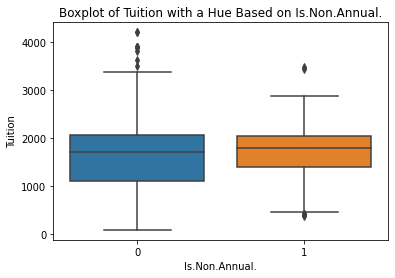

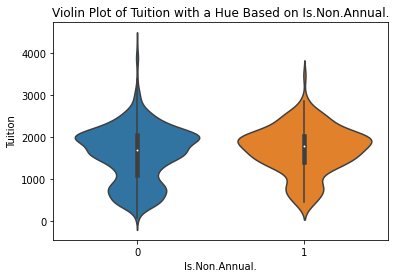

In [7]:
# Create a boxplot of Tuition with a hue based on Is.Non.Annual.
sns.boxplot(data=df, x='Is.Non.Annual.', y='Tuition')
# Add a title and y-axis label
plt.title('Boxplot of Tuition with a Hue Based on Is.Non.Annual.')
plt.ylabel('Tuition')
# Show the plot
plt.show()

# Create a violin plot of Tuition with a hue based on Is.Non.Annual.
sns.violinplot(data=df, x='Is.Non.Annual.', y='Tuition')
# Add a title and y-axis label
plt.title('Violin Plot of Tuition with a Hue Based on Is.Non.Annual.')
plt.ylabel('Tuition')
# Show the plot
plt.show()

La dispersión del grupo que no se logra retener es mayor del que sí, también genera bastante interés que la mediana del grupo que no se logra retener es menor al grupo que se retuvo. Por otra parte en el gráfico de violín se observa que hay dos distribuciones difirentes, es decir el grupo que no se logró retener tiene una posible distribución bimodal.

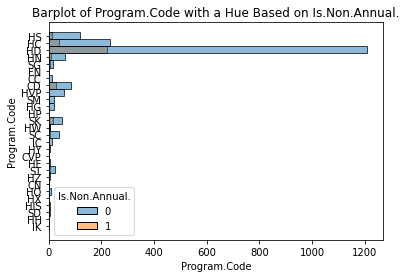

In [8]:
# Create the histogram
sns.histplot(data=df, y='Program.Code', hue='Is.Non.Annual.')

# Add a title and x-axis label
plt.title('Barplot of Program.Code with a Hue Based on Is.Non.Annual.')
plt.xlabel('Program.Code')

# Show the plot
plt.show()

La mayor cantidad de viajeros no se lograron detener por programa, pero exiten tres grupos que podrian ser el core del negocio (HD, HC y HS) 

In [9]:
import datetime
df = df.copy()
df['Departure.Date'] = pd.to_datetime(df['Departure.Date'], unit='d', origin=pd.Timestamp('1900-01-01'))
df['Return.Date'] = pd.to_datetime(df['Return.Date'], unit='d', origin=pd.Timestamp('1900-01-01'))
df['travel_days'] = (df['Return.Date'] - df['Departure.Date']).dt.days
df

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.,travel_days
0,1,HS,4.0,4.0,CA,0,1,A,2011-01-16,2011-01-16,...,Elementary,K->Elementary,H,1,0.06364617,0.936508,4,L,1,0
1,2,HC,8.0,8.0,AZ,0,7,A,2011-01-16,2011-01-23,...,Middle,Middle->Middle,H,1,0.025882353,0.880000,3,L,1,7
2,3,HD,8.0,8.0,FL,0,3,A,2011-01-17,2011-01-19,...,Middle,Middle->Middle,H,1,0.02513089,0.888889,3,L,1,2
3,4,HN,9.0,12.0,VA,1,3,B,2011-01-17,2011-01-19,...,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0,2
4,5,HD,6.0,8.0,FL,0,6,T,2011-01-18,2011-01-23,...,Middle,Middle->Middle,H,0,0.1125,0.910112,8,M-L,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,2385,HC,7.0,8.0,CA,0,5,A,2011-06-30,2011-07-04,...,Middle,Middle->Middle,H,0,0.018980477,0.921053,3,L,0,4
2385,2386,HD,8.0,8.0,CA,0,5,A,2011-07-01,2011-07-05,...,Middle,K->Middle,H,1,0.034782609,0.909091,2,S-M,1,4
2386,2387,HD,10.0,12.0,CA,0,6,A,2011-07-01,2011-07-07,...,Undefined,Undefined->Undefined,H,0,NaN,0.882353,4,NaN,1,6
2387,2388,HS,4.0,4.0,CA,0,1,A,2011-07-02,2011-07-02,...,Undefined,Undefined->Undefined,H,1,NaN,0.941176,1,NaN,1,0


<Figure size 2160x2160 with 0 Axes>

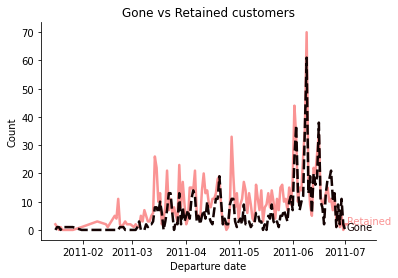

In [10]:
df_viaje = df.copy()
df_viaje = df_viaje[['Departure.Date', 'travel_days', 'Retained.in.2012.']]
df_viaje['gone'] = 1 -df_viaje['Retained.in.2012.']
# df_viaje

df_d = df_viaje.groupby(['Departure.Date']).agg(
    Retained = ('Retained.in.2012.','sum'),
    Gone = ('gone', 'sum'))
# df_d
import seaborn as sns
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots()
ax = sns.lineplot(data=df_d, linewidth=2.5, palette=['#FA9494', '#140303'], legend=None, linestyle='solid')
for line, name in zip(ax.lines, df_d.columns.tolist()):
	y = line.get_ydata()[-1]
	x = line.get_xdata()[-1]
	if not np.isfinite(y):
	    y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
	if not np.isfinite(y) or not np.isfinite(x):
	    continue     
	text = ax.annotate(name,
		       xy=(x, y),
		       xytext=(0, 0),
		       color=line.get_color(),
		       xycoords=(ax.get_xaxis_transform(),
				 ax.get_yaxis_transform()),
		       textcoords="offset points")
	text_width = (text.get_window_extent(
	fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
	if np.isfinite(text_width):
		ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
ax.set(xlabel='Departure date', ylabel='Count', title='Gone vs Retained customers')
#ax.legend(title='Type', title_fontsize = 13)
sns.despine(bottom=False, left=False)
plt.grid(False)
plt.show()

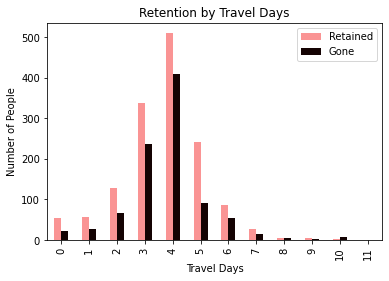

In [11]:
df_t = df_viaje.groupby(['travel_days']).agg(
    Retained = ('Retained.in.2012.','sum'),
    Gone = ('gone', 'sum'))


df_t.plot(kind='bar', y=['Retained', 'Gone'], color = ['#FA9494', '#140303'])

plt.xlabel('Travel Days')
plt.ylabel('Number of People')
plt.title('Retention by Travel Days')

plt.show()

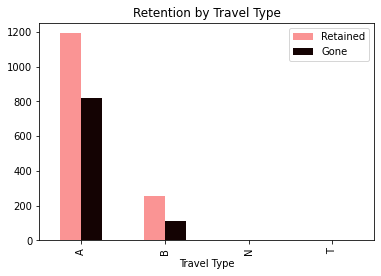

In [12]:
df_tp = df.copy()
df_tp = df_tp[['Travel.Type', 'Retained.in.2012.']]
df_tp['gone'] = 1 - df_tp['Retained.in.2012.']

df_tp = df_tp.groupby(['Travel.Type']).agg(
    Retained = ('Retained.in.2012.','sum'),
    Gone = ('gone', 'sum'))

df_tp.plot(kind='bar', y=['Retained', 'Gone'], color = ['#FA9494', '#140303'],)

plt.xlabel('Travel Type')
plt.title('Retention by Travel Type')

plt.show()

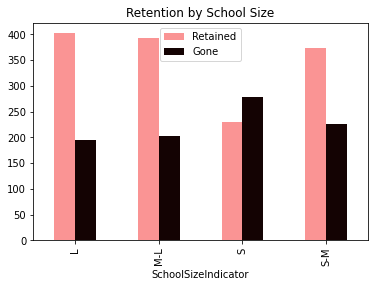

In [13]:
df_ss = df.copy()
df_ss = df_ss[['SchoolSizeIndicator', 'Retained.in.2012.']]
df_ss['gone'] = 1 - df_ss['Retained.in.2012.']

df_ss = df_ss.groupby(['SchoolSizeIndicator']).agg(
    Retained = ('Retained.in.2012.','sum'),
    Gone = ('gone', 'sum'))

df_ss.plot(kind='bar', y=['Retained', 'Gone'], color = ['#FA9494', '#140303'],)


plt.title('Retention by School Size')

plt.show()

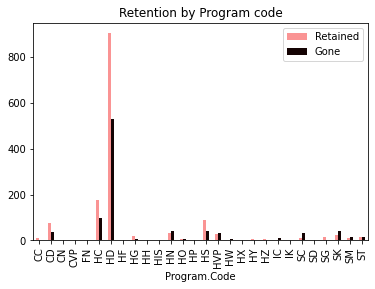

In [14]:
df_pc = df.copy()
df_pc = df_pc[['Program.Code', 'Retained.in.2012.']]
df_pc['gone'] = 1 - df_pc['Retained.in.2012.']

df_pc = df_pc.groupby(['Program.Code']).agg(
    Retained = ('Retained.in.2012.','sum'),
    Gone = ('gone', 'sum'))

df_pc.plot(kind='bar', y=['Retained', 'Gone'], color = ['#FA9494', '#140303'],)


plt.title('Retention by Program code')

plt.show()


# Limpieza de Datos

Nos entregan una base de datos que tiene demasiadas variables categóricas que pueden o no aportar información para el modelo. A continuación se limpiarán las categorías y se hará imputación de datos en caso de que haya variables faltantes. 

In [15]:
df = df.drop(columns = ['FirstMeeting', 'LastMeeting', 'Initial.System.Date', 'Early.RPL', 'Latest.RPL', 'Departure.Date', 'Return.Date', 'Deposit.Date', 'ID', 'travel_days'])

In [16]:
df.columns

Index(['Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Special.Pay', 'Tuition',
       'FRP.Active', 'FRP.Cancelled', 'FRP.Take.up.percent.', 'Cancelled.Pax',
       'Total.Discount.Pax', 'Poverty.Code', 'Region', 'CRM.Segment',
       'School.Type', 'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate',
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 'FPP',
       'Total.Pax', 'SPR.Group.Revenue', 'NumberOfMeetingswithParents',
       'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting',
       'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType',
       'DepartureMonth', 'GroupGradeTypeLow', 'GroupGradeTypeHigh',
       'GroupGradeType', 'MajorProgramCode', 'SingleGradeTripFlag',
       'FPP.to.School.enrollment', 'FPP.to.PAX', 'Num.of.Non_FPP.PAX',
       'SchoolSizeIndicator', 'Retained.in.2012.'],
      dtype=

In [17]:
## Asignación de tipos categóricos

categorical_features = ['From.Grade', 'To.Grade', 'Group.State', 'Travel.Type', 'Poverty.Code', 'CRM.Segment', 'School.Type', 'Parent.Meeting.Flag', 
                        'MDR.High.Grade', 'School.Sponsor', 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'GroupGradeTypeLow', 'GroupGradeTypeHigh',
                        'MajorProgramCode', 'SingleGradeTripFlag', 'SchoolSizeIndicator', 'Region', 'Special.Pay',    
                        'Income.Level', 'SPR.Product.Type', 'SPR.New.Existing', 'DepartureMonth', 'MDR.Low.Grade', 
                        'FPP.to.School.enrollment', 'GroupGradeType', 'Program.Code', 'SchoolGradeType']

df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))



## División en Train y Test

Antes de comenzar con la limpieza de datos (que es inputación de missing values, estandarizaciones, etc...) es importante realizar la división en train-test. No queremos codificar en los datos de entrenamiento información de los datos de prueba... 

Para esto, utilice la función de [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [18]:
from sklearn.model_selection import train_test_split

y = 1 - df['Retained.in.2012.'] # Se transforma la variable objetivo, para poder establecer 
#como objetivo los clientes que no viajaron con la compañia.
X = df.drop(columns = 'Retained.in.2012.')

### Utilice train_test_split para dividir los datos en entrenamiento y test. 

# Deje que el tamaño de test sea de 30%
# Random Sate: 42 para fines comparativos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                                                    
###

Verifique que la concentración de la variable dependiente sea similar en la base de entrenamiento y en la de validación.

In [19]:
y_test.value_counts()/len(y_test)

0    0.589958
1    0.410042
Name: Retained.in.2012., dtype: float64

In [20]:
y_train.value_counts()/len(y_train)

0    0.614833
1    0.385167
Name: Retained.in.2012., dtype: float64

## Missing Values

A continuación se realizará la inputación de valores faltantes. Utilizando el método `X_train.isna().sum()`

In [21]:
pd.DataFrame(X_train.isna().sum()/len(X_train))

,0
Program.Code,0.000000
From.Grade,0.054426
To.Grade,0.064593
Group.State,0.000000
Is.Non.Annual.,0.000000
Days,0.000000
Travel.Type,0.000000
Special.Pay,0.805622
Tuition,0.000000
FRP.Active,0.000000


Se observa que hay pocas columnas con valores faltantes. El 14% de los datos de entrenamiento no tuvo reuniones de padres, y el 25% no tiene asignado un código de pobreza. Es importante inputar los valores faltantes para poder realizar el entrenamiento. 

Utilice el método de [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) para entrenar un imputador para variables categóricas y variables numéricas. 

In [22]:
from sklearn.impute import SimpleImputer

categorical_columns = X_train.select_dtypes(exclude = [int, float]).columns
numerical_columns = X_train.select_dtypes(include = [int, float]).columns

### Imputador de Variables Categóricas -- strategy -> constant

categorical_imputer =  SimpleImputer(missing_values=np.nan, strategy='most_frequent')
###

In [23]:
### Imputador de Variables Numéricas -- strategy -> Median
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
###

In [24]:
categorical_imputer.fit(X_train[categorical_columns])

SimpleImputer(strategy='most_frequent')

In [25]:
numerical_imputer.fit(X_train[numerical_columns])

SimpleImputer()

In [26]:
# Utilice los imputers para inputar valores faltantes tanto en train como en test

###
X_train[categorical_columns] = categorical_imputer.transform(X_train[categorical_columns])
X_test[categorical_columns] = categorical_imputer.transform(X_test[categorical_columns])

X_train[numerical_columns] = numerical_imputer.transform(X_train[numerical_columns])
X_test[numerical_columns] = numerical_imputer.transform(X_test[numerical_columns])
###

In [27]:
# Verifique que efectivamente no tenga valores faltantes

###
pd.DataFrame(X_train.isna().sum()/len(X_train))

###

,0
Program.Code,0.0
From.Grade,0.0
To.Grade,0.0
Group.State,0.0
Is.Non.Annual.,0.0
Days,0.0
Travel.Type,0.0
Special.Pay,0.0
Tuition,0.0
FRP.Active,0.0


## Revisión Categorías

En la base de datos existe un gran número de variables categóricas. Se debe decidir de qué manera codificar la información (si requiere) para que el modelo pueda utilizarla. 

En principio, note que hay variables en las que hay categorías con pocas observaciones. Por ejemplo, la variable `From.Grade` tiene los siguientes conteos:


|               |   From.Grade |
|:--------------|-------------:|
| 8.0           |          786 |
| 7.0           |          365 |
| 6.0           |          159 |
| 4.0           |          109 |
| missing_value |           91 |
| 5.0           |           67 |
| 9.0           |           47 |
| 11.0          |           19 |
| 10.0          |           19 |
| 12.0          |            5 |
| 3.0           |            5 |

Se puede apreciar que la categoría 3 y 12 tienen 5 observaciones. Lo ideal es agrupar las categorías que tienen menos observaciones en una nueva categoría como "Otra".

In [28]:
for column in categorical_columns:
  categorical_counts = pd.value_counts(X_train[column])
  grouper = (categorical_counts/categorical_counts.sum() * 100).lt(2) # Selecciona aquellas con < 2% de observaciones
  X_train[column] = np.where(X_train[column].isin(categorical_counts[grouper].index),'Otra',X_train[column]) # Reemplaza en columna original
  X_test[column] = np.where(X_test[column].isin(categorical_counts[grouper].index),'Otra',X_test[column])

In [29]:
X_train['From.Grade'].value_counts()

8.0     877
7.0     365
6.0     159
4.0     109
5.0      67
Otra     48
9.0      47
Name: From.Grade, dtype: int64

## Variables Dummies

Algunas de las variables categóricas necesitan ser codificadas para poder entrar al modelo. Particularmente aquellas categorías que no son ordinales, como los estados donde se ubican los colegios. Por esta razón, utilizaremos One-Hot Encoding, para volver una variable categórica en un conjunto de variables binarias.

Utilice el método [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) para extraer las dummies de variables categóricas.


<div class="alert alert-block alert-danger">
<b>Cuidado:</b> Utilizar un número excesivo de variables dummies puede afectar negativamente el desempeño del modelo.
</div>

In [30]:
X_train.head()

,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Special.Pay,Tuition,FRP.Active,...,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator
380,HD,7.0,8.0,WA,0.0,4.0,A,FR,1912.0,4.0,...,March,Middle,Middle,Middle->Middle,H,0,Otra,0.888889,1.0,M-L
226,HD,8.0,8.0,CO,0.0,4.0,A,FR,1539.0,7.0,...,March,Middle,Middle,Middle->Middle,H,1,Otra,0.875000,2.0,S
1073,HD,8.0,8.0,CA,0.0,7.0,A,FR,2754.0,19.0,...,May,PK,Middle,PK->Middle,H,1,Otra,0.945946,2.0,S
715,HC,8.0,8.0,CA,0.0,6.0,A,FR,2549.0,30.0,...,April,Middle,Middle,Middle->Middle,H,1,Otra,0.882353,6.0,L
1195,HD,8.0,8.0,OH,0.0,6.0,B,SA,869.0,0.0,...,May,Elementary,Middle,Elementary->Middle,H,1,Otra,0.912409,12.0,M-L


In [31]:
pd.get_dummies(X_train[categorical_columns])

c:\Users\L57759\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Program.Code_CD,Program.Code_HC,Program.Code_HD,Program.Code_HN,Program.Code_HS,Program.Code_HVP,Program.Code_Otra,Program.Code_SC,Program.Code_SK,From.Grade_4.0,...,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_0,SingleGradeTripFlag_1,FPP.to.School.enrollment_0.1,FPP.to.School.enrollment_Otra,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M
380,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
226,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1073,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
715,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1195,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1095,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1130,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
1294,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [32]:
###
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test) # Pero igual debemos asegurarnos que no haya "dummies de más"
###

c:\Users\L57759\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
c:\Users\L57759\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [33]:
X_train, X_test = X_train.align(X_test, fill_value = 0, axis = 1, join = 'left') # Alineamos datos para mantener mismas columnas

In [34]:
X_train.head()

,Is.Non.Annual.,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,...,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_0,SingleGradeTripFlag_1,FPP.to.School.enrollment_0.1,FPP.to.School.enrollment_Otra,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M
380,0.0,4.0,1912.0,4.0,1.0,0.500,1.0,1.0,772.0,0.750,...,0,0,1,0,0,1,0,1,0,0
226,0.0,4.0,1539.0,7.0,2.0,0.500,3.0,2.0,230.0,0.286,...,0,0,0,1,0,1,0,0,1,0
1073,0.0,7.0,2754.0,19.0,1.0,0.543,1.0,2.0,250.0,0.114,...,0,0,0,1,0,1,0,0,1,0
715,0.0,6.0,2549.0,30.0,5.0,0.667,3.0,6.0,1027.0,0.289,...,0,0,0,1,0,1,1,0,0,0
1195,0.0,6.0,869.0,0.0,0.0,0.000,9.0,12.0,790.0,0.000,...,0,0,0,1,0,1,0,1,0,0


In [35]:
X_test.head()

,Is.Non.Annual.,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,...,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_0,SingleGradeTripFlag_1,FPP.to.School.enrollment_0.1,FPP.to.School.enrollment_Otra,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M
1320,0.0,1.0,384.0,19.0,1.0,0.475,3.0,2.0,407.0,0.200,...,0,0,0,1,0,0,0,0,0,1
1412,0.0,5.0,2117.0,14.0,2.0,0.667,0.0,2.0,184.0,0.286,...,0,0,0,1,0,1,0,0,1,0
530,0.0,5.0,736.0,29.0,6.0,0.460,4.0,4.0,500.0,0.111,...,0,0,0,1,0,0,0,0,0,1
554,0.0,5.0,1799.0,13.0,2.0,0.929,3.0,1.0,761.0,0.071,...,0,0,0,1,0,1,0,1,0,0
229,0.0,3.0,1058.0,19.0,1.0,0.704,1.0,5.0,334.0,0.185,...,0,0,1,0,0,0,0,0,1,0


En este punto, los datos de entrenamiento y prueba tienen las mismas características y están codificados de la misma forma basado en la información de entrenamiento. Con lo anterior, es posible entrenar los modelos que queramos para predicción.

# Modelamiento

En esta sección se realizará
- Línea Base
- Support Vector Machine

contigency = pd.crosstab(xx['Is.Non.Annual.'], xx['Gone'])
## Línea Base -- Sencilla

Lo ideal al resolver un problema de Machine Learning es siempre tener una línea base de comparación. Usualmente se utiliza un modelo previo, alguna heurística,el modelo más sencillo al alcance o lo que hubiera hecho un humano. En este caso contamos con información de una variable binaria que podría ser un muy buen predictor de no reserva el siguiente año: 

> `Is.Non.Annual.`: Variable binaria que indica si el grupo suele saltarse un año entre programas de viaje. Aquellos que se suelen saltar el año, muy rara vez viajan el año siguiente. 

Utilice esta variable para construir una línea base de comparación.

In [36]:
xx = X_train[['Is.Non.Annual.']].astype(int)
pe = xx
pe['Gone'] = y_train.astype(int)
contigency = pd.crosstab(xx['Is.Non.Annual.'], xx['Gone'], normalize='index')
contigency

Gone,0,1
Is.Non.Annual.,,
0,0.698233,0.301767
1,0.155642,0.844358


In [37]:
### Determine qué proporción de observaciones tienen 1 en este campo

X_train['Is.Non.Annual.'].value_counts()/len(X_train)

### ¿Qué puede decir de su resultado?

0.0    0.846292
1.0    0.153708
Name: Is.Non.Annual., dtype: float64

Relacionado con lo que fue encontrado en los gráficos de mosaico, se ve la relación  inversa entre la variable de 'Is.Non.Annual.' con la variable de respuesta por lo que se realizara un modelo ingenuo, donde sea el valor inverso del mismo.

In [38]:
### Utilice esta información para crear una predicción (sin un modelo) -> Train y Test
y_naive_train = X_train['Is.Non.Annual.'].copy()
y_naive_test = X_test['Is.Non.Annual.'].copy()
###

A continuación deberemos revisar el desempeño de nuestra línea base. Para ello, sugerimos utilizar las siguientes herramientas:

- [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [`sklearn.metrics.classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [`sklearn.metrics.ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1028
           1       0.84      0.34      0.48       644

    accuracy                           0.72      1672
   macro avg       0.77      0.65      0.65      1672
weighted avg       0.75      0.72      0.68      1672

El "Accuracy" en train es: 0.721


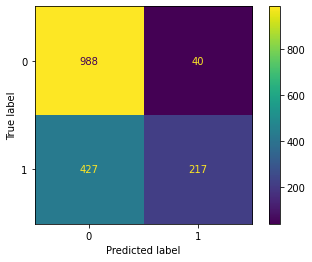

In [39]:
### Evalúe el desempeño de su modelo en train -- Accuracy, Matriz de Confusión, F1, Precisión, Recall...

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_train, y_naive_train))
print('El "Accuracy" en train es:',round(accuracy_score(y_train, y_naive_train),3))

cm = confusion_matrix(y_train, y_naive_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
###


              precision    recall  f1-score   support

           0       0.67      0.96      0.79       423
           1       0.83      0.31      0.45       294

    accuracy                           0.69       717
   macro avg       0.75      0.63      0.62       717
weighted avg       0.73      0.69      0.65       717

El "Accuracy" en test es: 0.692


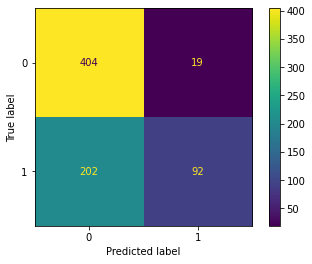

In [40]:
### Evalúe el desempeño de su modelo en test -- Accuracy, Matriz de Confusión, F1, Precisión, Recall...

print(classification_report(y_test, y_naive_test))
print('El "Accuracy" en test es:',round(accuracy_score(y_test, y_naive_test),3))

cm = confusion_matrix(y_test, y_naive_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
###

###


In [41]:
y_test.value_counts(normalize=True)

0    0.589958
1    0.410042
Name: Retained.in.2012., dtype: float64

Se puede concluir, que el modelo basándonos netamente en los clientes que suelen saltarse años para realizar uso de estos viajes, tiene un accuracy interesante, ya que tiene un f-score de 0,79 que denota un buen nivel predictivo. logrando ser preciso con los clientes que pueden irse.

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score

d = {'Modelo': ['Linea_base'], 
     'Precision': [precision_score(y_test, y_naive_test)], 
     'Recall': recall_score(y_test, y_naive_test),
     'Accuracy': accuracy_score(y_test, y_naive_test),
     'F1_Score': f1_score(y_test, y_naive_test),
     'AUC': roc_auc_score(y_test, y_naive_test)}
Resultados = pd.DataFrame(data=d)
Resultados

,Modelo,Precision,Recall,Accuracy,F1_Score,AUC
0,Linea_base,0.828829,0.312925,0.691771,0.454321,0.634004


In [43]:
roc_auc_score(y_test, y_naive_test)

0.634003956192406

## Support Vector Machine -- Default

En esta sección se entrenará un modelo de SVM utilizando los parámetros por defcto del modelo. Siempre es bueno conocer cómo se desempeña el modelo sin optimizar hiperparámetros para determinar su desempeño "base".

Para esto necesitaremos utilizar

- [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): Permitirá entrenar el modelo SVM
- [`sklearn.preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Para pre-procesamiento (básico) de features.
- [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): Para encadenamiento de pasos


In [44]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

np.random.seed(10)

# Encadene los pasos de Pre-Procesamiento y Modelo

###

model_steps = []
model_steps.append(('MinMaxScaling', MinMaxScaler())) # escalamos los datos
model_steps.append(('SVM', SVC(probability=True))) # definimos SVM(probability = True)

###


# Defina el Modelo utilizando el Pipeline
clf_default = Pipeline(model_steps, verbose=False)

In [45]:
# Ajuste el Modelo en los Datos de Entrenamiento
###

clf_default.fit(X_train, y_train)

###

Pipeline(steps=[('MinMaxScaling', MinMaxScaler()),
                ('SVM', SVC(probability=True))])

En este momento se tiene un modelo entrenado con los parámetros por defecto. A continuación se realizarán las predicciones y la evaluación del desempeño del modelo. 

La predicción se realiza utilizando los métodos `clf_deafult.predict` para la clase (1 o 0), y `clf_default.predict_proba` para predecir las probabilidades. Tenga en cuenta que al utilizar `predict_proba` se obtienen dos columnas, una con la probabilidad para la clase `0` y otra para la clase `1`.  

In [46]:
# Realice la Predicción de las clases

###

y_pred_default = clf_default.predict(X_test) # probabilidades

###


# Realice la predicción de las probabilidades

###
y_pred_default_proba = clf_default.predict_proba(X_test)[:,1] # probabilidades

###

## Métricas de Evaluación

De igual forma que con la línea base, es necesario realizar la evaluación del desempeño del modelo en train y en test. Adicionalmente a las métricas anteriores, se pide la evaluación utilizando la curva ROC y el AUC. 

- [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [47]:
# Evalúe el desempeño de su modelo en train -- Accuracy, Matriz de Confusión, F1, Precisión, Recall...


###
print(classification_report(y_test, y_pred_default))


###

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       423
           1       0.78      0.65      0.71       294

    accuracy                           0.78       717
   macro avg       0.78      0.76      0.77       717
weighted avg       0.78      0.78      0.78       717



In [48]:
# Realice el cálculo de la curva ROC

### 
from sklearn.metrics import roc_curve, roc_auc_score

false_positives_rate, true_positives_rate, threshold = roc_curve(y_test, y_pred_default_proba)
###

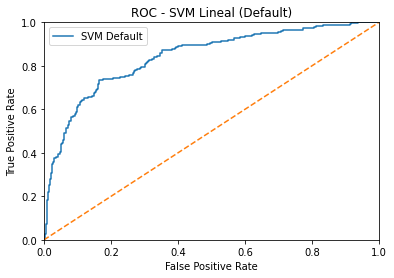

In [49]:
# Grafique la curva ROC

plt.title('ROC - SVM Lineal (Default)')
###


plt.plot(false_positives_rate, true_positives_rate, label = 'SVM Default')


###

plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

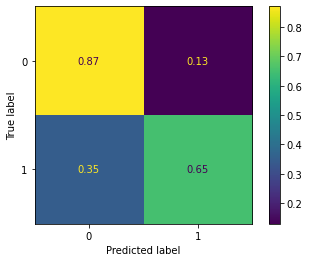

In [50]:
cm = confusion_matrix(y_test, y_pred_default, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [51]:
# Calcule el AUC del Modelo

###

print('AUC Score: ', roc_auc_score(y_test, y_pred_default_proba))

###

AUC Score:  0.8415191135555877


In [52]:
d1 = {'Modelo': ['SVM_1'], 
     'Precision': precision_score(y_test, y_pred_default), 
     'Recall': recall_score(y_test, y_pred_default),
     'Accuracy': accuracy_score(y_test, y_pred_default),
      'F1_Score': f1_score(y_test, y_pred_default),
      'AUC': roc_auc_score(y_test, y_pred_default_proba)}
Resultados1 = pd.DataFrame(data=d1)

Resultados = Resultados.append(Resultados1, ignore_index=True)
Resultados

C:\Users\L57759\AppData\Local\Temp\ipykernel_6032\3830876018.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append(Resultados1, ignore_index=True)


,Modelo,Precision,Recall,Accuracy,F1_Score,AUC
0,Linea_base,0.828829,0.312925,0.691771,0.454321,0.634004
1,SVM_1,0.777328,0.653061,0.781032,0.709797,0.841519


Este método, se percibe una mejora en nivel general de las métricas menos en la del recall.

# Utilización de Kernels -- Búsqueda de Hiperparámetros

No siempre el modelo con los parámetros por defecto suele ser el mejor. Sin embargo, sí suele dar un indicio del desempeño que se va a conseguir con el modelo. 

Una vez construída la línea base, se suele realizar la estimación utilizando una búsqueda de hiperparámetros. Esta búsqueda permite seleccionar los hiperparámetros óptimos para el modelo, de forma tal que genere el mejor desempeño posible.

## Búsqueda de la Mejor Combinación

Existen varias estrategias de búsqueda de hiperparámetros. En esta sección se utilizará principalmente [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), que nos permite definir una "malla" de parámetros sobre los cuales entrenar modelos. 

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
# Defina los hiperparametros que quiere probar

###

hyperparameters_grid = [{
    'SVM__kernel': ['linear', 'rbf'],  # Una lista con los kernels que desea probar
    'SVM__C': [0.1, 1, 5, 10], # Una lista con los valores de C para regularización
    'SVM__gamma': [0.05, 1.0, 1.3, 'auto'] # Una lista con los valores de gamma de los kernels
}]
###

In [55]:
Hyper_SVM = Pipeline(model_steps, verbose=False)

In [56]:
grid_search = GridSearchCV(Hyper_SVM, hyperparameters_grid, cv=5,  n_jobs=3)

In [57]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMaxScaling', MinMaxScaler()),
                                       ('SVM', SVC(probability=True))]),
             n_jobs=3,
             param_grid=[{'SVM__C': [0.1, 1, 5, 10],
                          'SVM__gamma': [0.05, 1.0, 1.3, 'auto'],
                          'SVM__kernel': ['linear', 'rbf']}])

### Selección del Mejor Modelo

En este punto se entrenaron tantos modelos como combinaciones de hiperparámetros definidos. Solo uno de ellos puede ser el mejor modelo. A continuación, obtenemos el mejor modelo de los entrenados y evaluamos su desempeño en test.

In [58]:
cv_performance = grid_search.best_score_
test_performance = grid_search.score(X_test, y_test)

In [59]:
print('Best parameter: {}'.format(str(grid_search.best_params_)))
print('Cross-validation accuracy score: {0:0.3f}'.format(cv_performance))

Best parameter: {'SVM__C': 0.1, 'SVM__gamma': 0.05, 'SVM__kernel': 'linear'}
Cross-validation accuracy score: 0.808


## Entrenamiento del Mejor Modelo

El mejor modelo fue entrenado utilizando Cross-Validation, por lo que no tenemos un modelo entrenado utilizando la totalidad de los datos de entrenamiento. Por esta razón, tomamos los hiperparámetros del mejor modelo y entrenamos uno nuevo.

In [60]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('MinMaxScaling', MinMaxScaler()),
                ('SVM',
                 SVC(C=0.1, gamma=0.05, kernel='linear', probability=True))])

Una vez entrenado, ya es posible realizar las predicciones y evaluar su desempeño para comparación con los modelos anteriores.

In [61]:
y_pred_hp = best_model.predict(X_test)
y_pred_prob_hp = best_model.predict_proba(X_test)[:,1]

In [62]:
print('AUC Score: ', roc_auc_score(y_test, y_pred_prob_hp))

AUC Score:  0.8427976391502228


In [63]:
false_positives_rate_hp, true_positives_rate_hp, threshold = roc_curve(y_test, y_pred_prob_hp)

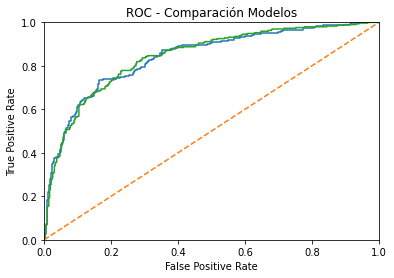

In [64]:
# Grafique la curva ROC para ambos modelos


plt.title('ROC - Comparación Modelos')

###

plt.plot(false_positives_rate, true_positives_rate, label = 'SVM Default')
plt.plot([0, 1], ls="--")
plt.plot(false_positives_rate_hp, true_positives_rate_hp, label = 'Tuned SVM')

###

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

In [65]:
print(classification_report(y_test, y_pred_hp))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       423
           1       0.77      0.66      0.71       294

    accuracy                           0.78       717
   macro avg       0.78      0.76      0.77       717
weighted avg       0.78      0.78      0.78       717



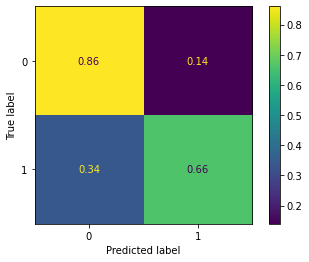

In [66]:
cm = confusion_matrix(y_test, y_pred_hp, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [67]:
d2 = {'Modelo': ['SVM_Grid'], 
     'Precision': precision_score(y_test, y_pred_hp), 
     'Recall': recall_score(y_test, y_pred_hp),
     'Accuracy': accuracy_score(y_test, y_pred_hp),
      'F1_Score': f1_score(y_test, y_pred_hp),
      'AUC': roc_auc_score(y_test, y_pred_prob_hp)}
Resultados2 = pd.DataFrame(data=d2)

Resultados = Resultados.append(Resultados2, ignore_index=True)
Resultados

C:\Users\L57759\AppData\Local\Temp\ipykernel_6032\3144806478.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append(Resultados2, ignore_index=True)


,Modelo,Precision,Recall,Accuracy,F1_Score,AUC
0,Linea_base,0.828829,0.312925,0.691771,0.454321,0.634004
1,SVM_1,0.777328,0.653061,0.781032,0.709797,0.841519
2,SVM_Grid,0.767717,0.663265,0.779637,0.711679,0.842798


# Regresion logistica

In [80]:
from sklearn.linear_model import LogisticRegression


clf_logistic = LogisticRegression(random_state=0)
clf_logistic.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=0)

In [69]:
y_pred_logistic = clf_logistic.predict(X_test) 
y_pred_logistic_proba = clf_logistic.predict_proba(X_test)[:,1] # probabilidades

## Métricas de Evaluación

De igual forma que con la línea base, es necesario realizar la evaluación del desempeño del modelo en train y en test. Adicionalmente a las métricas anteriores, se pide la evaluación utilizando la curva ROC y el AUC. 

- [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [70]:
# Evalúe el desempeño de su modelo en train -- Accuracy, Matriz de Confusión, F1, Precisión, Recall...


###
print(classification_report(y_test, y_pred_logistic))


###

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       423
           1       0.70      0.56      0.62       294

    accuracy                           0.72       717
   macro avg       0.71      0.70      0.70       717
weighted avg       0.72      0.72      0.71       717



In [71]:
# Realice el cálculo de la curva ROC

### 
from sklearn.metrics import roc_curve, roc_auc_score

false_positives_rate, true_positives_rate, threshold = roc_curve(y_test, y_pred_logistic_proba)
###

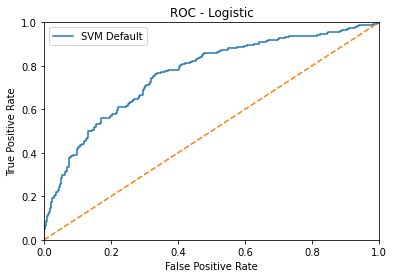

In [72]:
# Grafique la curva ROC

plt.title('ROC - Logistic')
###


plt.plot(false_positives_rate, true_positives_rate, label = 'SVM Default')


###

plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

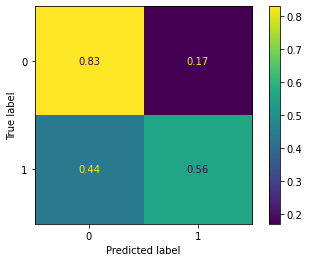

In [73]:
cm = confusion_matrix(y_test, y_pred_logistic, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [74]:
# Calcule el AUC del Modelo

###

print('AUC Score: ', roc_auc_score(y_test, y_pred_logistic_proba))

###

AUC Score:  0.762741030218234


In [75]:
d3 = {'Modelo': ['Regresión_Logistica'], 
     'Precision': precision_score(y_test, y_pred_logistic), 
     'Recall': recall_score(y_test, y_pred_logistic),
     'Accuracy': accuracy_score(y_test, y_pred_logistic),
      'F1_Score': f1_score(y_test, y_pred_logistic),
      'AUC': roc_auc_score(y_test, y_pred_logistic_proba)}
Resultados3 = pd.DataFrame(data=d3)

Resultados = Resultados.append(Resultados3, ignore_index=True)
Resultados

C:\Users\L57759\AppData\Local\Temp\ipykernel_6032\2272413246.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append(Resultados3, ignore_index=True)


,Modelo,Precision,Recall,Accuracy,F1_Score,AUC
0,Linea_base,0.828829,0.312925,0.691771,0.454321,0.634004
1,SVM_1,0.777328,0.653061,0.781032,0.709797,0.841519
2,SVM_Grid,0.767717,0.663265,0.779637,0.711679,0.842798
3,Regresión_Logistica,0.696203,0.561224,0.719665,0.621469,0.762741


# Interpretación de Resultados

¿Qué puede decir respecto a los resultados obtenidos de la línea base y el SVM? ¿Cómo impactan sus resultados al negocio de STC?

In [76]:
import shap

In [77]:
explainer = shap.Explainer(grid_search.predict, X_train)
shap_values = explainer(X_test)


Permutation explainer: 718it [12:58,  1.09s/it]                         


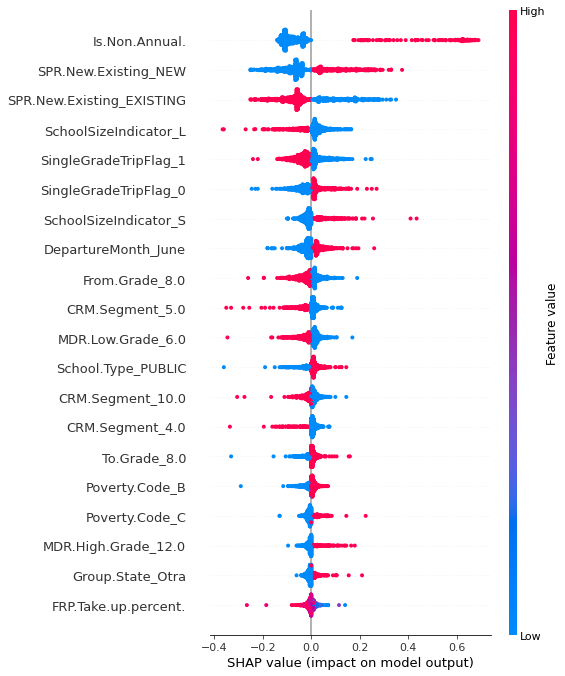

In [78]:
shap.summary_plot(shap_values)